# Document Classification



### 1. Environment Setup
Libraries include `transformers` for the ParsBERT model, `pandas` for data manipulation, `numpy` for numerical operations, `sklearn` for data splitting and evaluation metrics, `opendatasets` for downloading the dataset, and `torch` for PyTorch functionality. You can install these libraries using the following command:

In [ ]:
!pip install pandas numpy scikit-learn torch opendatasets datasets shap hazm
!pip install transformers[torch] -U

Please run this notebook in Google Colab with T4 GPU runtime. Check with this:

In [2]:
!nvidia-smi

Wed Feb 14 17:49:40 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### 2. Loading and Preparing the Data

Here, we'll load the dataset from the specified CSV file, then split it into training and testing sets with a 90-10 split. We won't create a separate validation set for the base model, as we're going to use cross-validation.

In [3]:
import opendatasets as od
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from hazm import Normalizer, word_tokenize, stopwords_list

# Download the dataset
od.download("https://www.kaggle.com/datasets/amirpourmand/tasnimdataset")
df = pd.read_csv("./tasnimdataset/tasnim.csv")

df = df.dropna(subset=['body'])
# For reducing the time of train
df = df.sample(frac=0.1, random_state=42)

# def preprocess_text(text):
#     normalizer = Normalizer()
#     tokens = word_tokenize(normalizer.normalize(text))
#     stop_words = set(stopwords_list())
#     tokens = [word for word in tokens if word not in stop_words]
#     return ' '.join(tokens)

# Apply preprocessing to the dataset
# df['body'] = df['body'].apply(preprocess_text)

label_encoder = LabelEncoder()
df['category_encoded'] = label_encoder.fit_transform(df['category'])

# Splitting the dataset into training and testing sets (90% train, 10% test)
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mahdisaadatbakht
Your Kaggle Key: ··········


100%|██████████| 84.7M/84.7M [00:01<00:00, 53.3MB/s]


### 3. Implementing the Base Model
For the base model, we'll use a TF-IDF vectorizer and a logistic regression classifier. We'll perform cross-validation to evaluate this base model.

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score

# Creating a pipeline with TF-IDF vectorization and Logistic Regression
pipeline_base = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=1000))

# Custom scorer for F1 macro and micro
scorers = {
    'f1_macro': make_scorer(f1_score, average='macro'),
    'f1_micro': make_scorer(f1_score, average='micro'),
    'precision': make_scorer(precision_score, average='macro'),
    'recall': make_scorer(recall_score, average='macro'),
}

# Execute cross-validation with multiple scoring metrics
scores = cross_validate(pipeline_base, train_df['body'], train_df['category_encoded'], cv=5, scoring=scorers)

print(f"Cross-validation scores:")
for score_name, score_values in scores.items():
    print(f"{score_name}: Mean = {score_values.mean()}, Std = {score_values.std()}")



Cross-validation scores:
fit_time: Mean = 20.276628923416137, Std = 3.45323348876905
score_time: Mean = 0.8112841129302979, Std = 0.23346987148216283
test_f1_macro: Mean = 0.8246725731115767, Std = 0.011276161728780622
test_f1_micro: Mean = 0.8269982238010657, Std = 0.01108382292136599
test_precision: Mean = 0.8274669070077764, Std = 0.010736786445141686
test_recall: Mean = 0.8282300130589102, Std = 0.011359742531450653


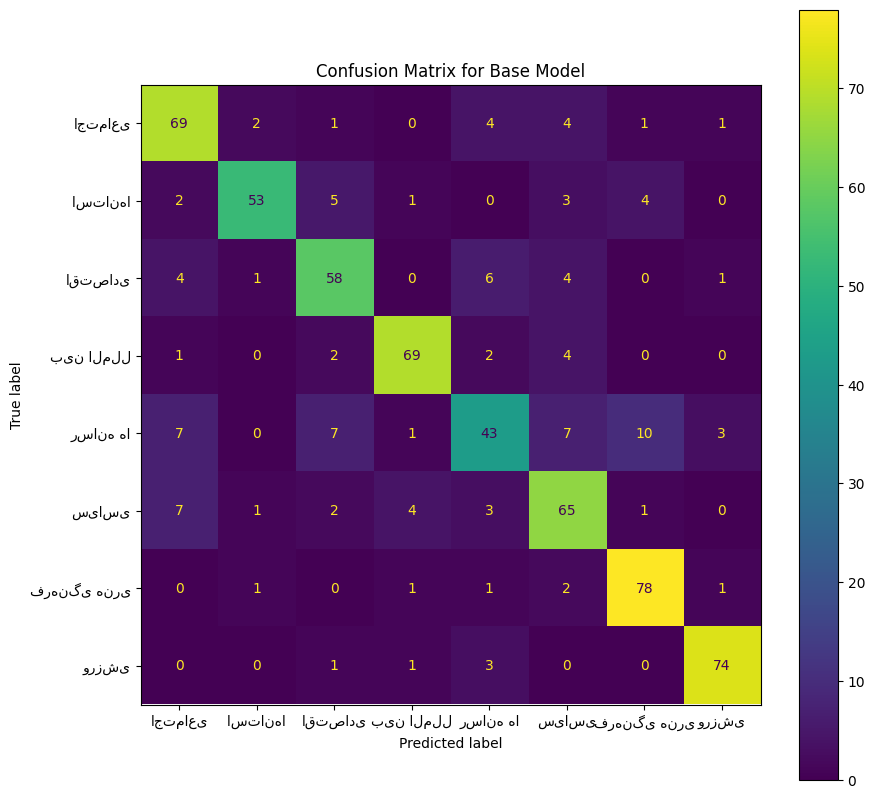

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# For the base model with Logistic Regression
pipeline_base.fit(train_df['body'], train_df['category_encoded'])
base_model_predictions = pipeline_base.predict(test_df['body'])
cm_base = confusion_matrix(test_df['category_encoded'], base_model_predictions)

# Plotting the confusion matrix for the base model
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay(cm_base, display_labels=label_encoder.classes_).plot(ax=ax)
plt.title("Confusion Matrix for Base Model")
plt.show()

### 4. Implementing the Main Model with ParsBERT
For the main model, we'll use ParsBERT. First, we need to load the model and tokenizer. Then, we prepare our dataset for training by tokenizing the texts.


In [26]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("HooshvareLab/bert-base-parsbert-uncased")

# Function to tokenize the text
def tokenize_function(examples):
    return tokenizer(examples["body"], padding="max_length", truncation=True, max_length=128)

# Create Hugging Face Dataset objects from pandas dataframes
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

# Tokenizing the datasets
train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Ensure that the 'labels' column is of type 'int'
train_dataset = train_dataset.rename_column("category_encoded", "labels")
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset = test_dataset.rename_column("category_encoded", "labels")
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/5630 [00:00<?, ? examples/s]

Map:   0%|          | 0/626 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at HooshvareLab/bert-base-parsbert-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Micro,F1 Macro,Precision,Recall
1,No log,0.148311,0.966454,0.966454,0.966630,0.967659,0.966455
2,No log,0.119071,0.971246,0.971246,0.971054,0.971463,0.971120
3,No log,0.135178,0.969649,0.969649,0.969330,0.969759,0.969345


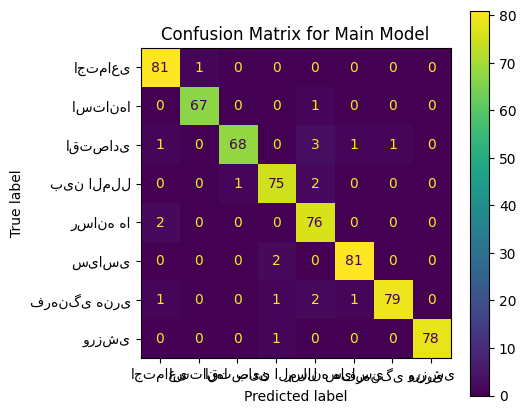

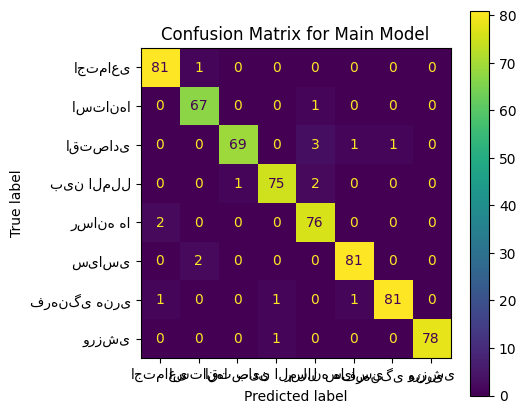

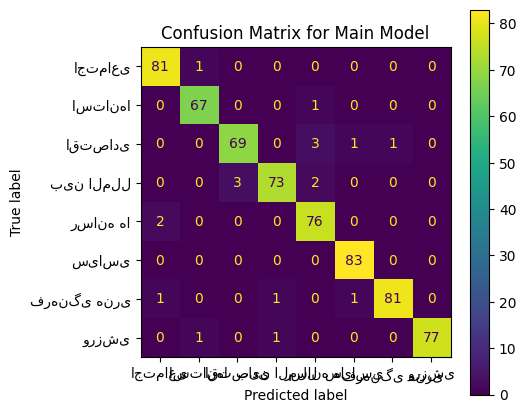

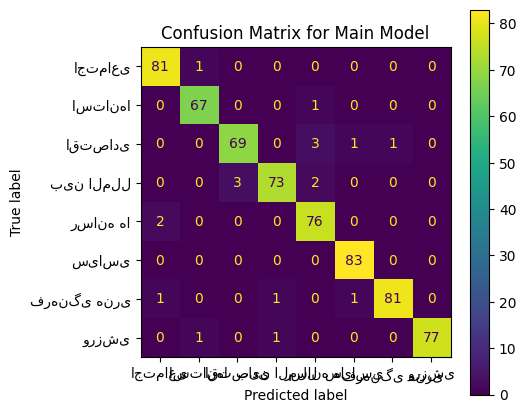

eval_loss: 0.13517817854881287
eval_accuracy: 0.9696485623003195
eval_f1_micro: 0.9696485623003195
eval_f1_macro: 0.9693297486795671
eval_precision: 0.9697589510353453
eval_recall: 0.9693446371217742
eval_runtime: 3.1129
eval_samples_per_second: 201.101
eval_steps_per_second: 25.379
epoch: 3.0


In [28]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from transformers import EvalPrediction

# Load the model
model = AutoModelForSequenceClassification.from_pretrained("HooshvareLab/bert-base-parsbert-uncased", num_labels=len(df['category'].unique()))

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=64,
    evaluation_strategy="epoch",
    fp16=True,
)

# Updating the compute_metrics function to include confusion matrix for the main model
def compute_metrics_with_cm(p: EvalPrediction):
    preds = np.argmax(p.predictions, axis=1)
    cm = confusion_matrix(p.label_ids, preds)
    fig, ax = plt.subplots(figsize=(5, 5))
    ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_).plot(ax=ax)
    plt.title("Confusion Matrix for Main Model")
    plt.show()
    return {
        'accuracy': accuracy_score(p.label_ids, preds),
        'f1_micro': f1_score(p.label_ids, preds, average='micro'),
        'f1_macro': f1_score(p.label_ids, preds, average='macro'),
        'precision': precision_score(p.label_ids, preds, average='macro'),
        'recall': recall_score(p.label_ids, preds, average='macro'),
        # Confusion matrix will not be returned as a metric but displayed using matplotlib
    }

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics_with_cm,
)

# Train
trainer.train()

# Evaluate
results = trainer.evaluate()

for metric_name, metric_value in results.items():
  print(metric_name + ':', metric_value)
